Creates dataframe of individual fight data using the information in the json files

In [324]:
import pandas as pd 
import json 
import os 
import numpy as np

folder_path = 'events'  
fight_rows = []

# Loop through all JSON files
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        with open(os.path.join(folder_path, filename), 'r') as f:
            data = json.load(f)

        date = data.get("date")
        event = data.get("event")

        for key, fight in data.items():
            if isinstance(fight, dict) and 'fighter1' in fight and 'fighter2' in fight:
                f1_data = fight.get('fighter1_fight_data') or {}
                f2_data = fight.get('fighter2_fight_data') or {}

                row = {
                    'event': event,
                    'date': date,
                    'fight_name': fight.get('name'),
                    'f1': fight.get('fighter1'),
                    'f2': fight.get('fighter2'),
                    'winner': fight.get('winner'),
                    'method': fight.get('method'),
                    'fight_length': fight.get('fight_length')
                }

                # Add all fighter1 stats with prefix f1_
                for stat, value in f1_data.items():
                    row[f'f1_{stat}'] = value

                # Add all fighter2 stats with prefix f2_
                for stat, value in f2_data.items():
                    row[f'f2_{stat}'] = value

                fight_rows.append(row)

# Create DataFrame
fight_df = pd.DataFrame(fight_rows)
fight_df['date'] = pd.to_datetime(fight_df['date'], errors='coerce')

fight_df.sort_values(by='date', inplace=True)
fight_df.to_csv('fight_df.csv')

Create a new dataframe of features to analyze

In [377]:

def calculate_fighter_historical_averages(fight_df):
    """
    Calculate historical averages for each fighter prior to each fight.
    
    Args:
        fight_df: DataFrame with fight data
    
    Returns:
        DataFrame with historical averages added for each fighter
    """
    
    # Ensure the dataframe is sorted by date
    fight_df = fight_df.sort_values('date').reset_index(drop=True)
    
    # Define the stat columns we want to calculate averages for
    stat_columns = [
        'kd', 'sig_str_landed', 'sig_str_att', 'str_landed', 'str_att',
        'td_comp', 'td_att', 'sub_att', 'ctrl_time'
    ]
    
    # Create a list to store results
    results = []
    
    # Process each fight
    for idx, fight in fight_df.iterrows():
        fight_result = fight.copy()
        
        # Get fights prior to current fight for each fighter
        prior_fights = fight_df.iloc[:idx]  # All fights before current fight
        
        # Calculate averages for fighter 1 (f1)
        f1_prior = get_fighter_prior_fights(prior_fights, fight['f1'])
        for stat in stat_columns:
            f1_col = f'f1_{stat}'
            avg_col = f'f1_avg_{stat}'
            fight_result[avg_col] = f1_prior[f1_col].mean() if len(f1_prior) > 0 else np.nan
        
        # Calculate averages for fighter 2 (f2)
        f2_prior = get_fighter_prior_fights(prior_fights, fight['f2'])
        for stat in stat_columns:
            f2_col = f'f2_{stat}'
            avg_col = f'f2_avg_{stat}'
            fight_result[avg_col] = f2_prior[f2_col].mean() if len(f2_prior) > 0 else np.nan
        
        results.append(fight_result)
    
    return pd.DataFrame(results)

def get_fighter_prior_fights(prior_fights_df, fighter_name):
    """
    Get all prior fights for a specific fighter (as either f1 or f2).
    """
    # Fighter could be in either f1 or f2 position
    f1_fights = prior_fights_df[prior_fights_df['f1'] == fighter_name].copy()
    f2_fights = prior_fights_df[prior_fights_df['f2'] == fighter_name].copy()
    
    # For f2 fights, we need to swap the column names to match f1 format
    if len(f2_fights) > 0:
        # Create a mapping to swap f1/f2 stats
        stat_columns = [
            'kd', 'sig_str_landed', 'sig_str_att', 'str_landed', 'str_att',
            'td_comp', 'td_att', 'sub_att', 'ctrl_time'
        ]
        
        for stat in stat_columns:
            f1_col = f'f1_{stat}'
            f2_col = f'f2_{stat}'
            # Swap the values
            f2_fights[f1_col] = f2_fights[f2_col]
    
    # Combine all fights and return only the f1 columns (since we normalized everything to f1 format)
    all_fights = pd.concat([f1_fights, f2_fights], ignore_index=True)
    return all_fights

# Example usage:
# Make sure your fight_df has the correct column names and is loaded
# fight_df_with_averages = calculate_fighter_historical_averages(fight_df)

# You can also add additional metrics like win rate, finish rate, etc.
def add_additional_fighter_metrics(fight_df_with_averages):
    """
    Add historical metrics: win rate, finish rate, total fights, and pre-fight ELO rating.
    """
    results = []
    elo_ratings = {}  # Store evolving ELO ratings
    
    base_rating = 1500  # Starting ELO

    for idx, fight in fight_df_with_averages.iterrows():
        fight_result = fight.copy()
        prior_fights = fight_df_with_averages.iloc[:idx]

        for fighter_col, prefix in [('f1', 'f1_'), ('f2', 'f2_')]:
            fighter_name = fight[fighter_col]
            fighter_prior = get_fighter_prior_fights(prior_fights, fighter_name)

            if len(fighter_prior) > 0:
                wins = (fighter_prior['winner'] == fighter_name).sum()
                finishes = fighter_prior[
                    (fighter_prior['winner'] == fighter_name) & 
                    (fighter_prior['method'].isin(['KO/TKO', 'Submission']))
                ].shape[0]

                fight_result[f'{prefix}win_rate'] = wins / len(fighter_prior)
                fight_result[f'{prefix}finish_rate'] = finishes / len(fighter_prior)
                fight_result[f'{prefix}total_fights'] = len(fighter_prior)
            else:
                fight_result[f'{prefix}win_rate'] = np.nan
                fight_result[f'{prefix}finish_rate'] = np.nan
                fight_result[f'{prefix}total_fights'] = 0

        f1 = fight['f1']
        f2 = fight['f2']
        winner = fight['winner']

        # Get pre-fight ELOs (default to base)
        f1_elo = elo_ratings.get(f1, base_rating)
        f2_elo = elo_ratings.get(f2, base_rating)

        fight_result['f1_elo'] = f1_elo
        fight_result['f2_elo'] = f2_elo

        # Update ELOs after the fight
        e1 = 1 / (1 + 10 ** ((f2_elo - f1_elo) / 400))
        e2 = 1 - e1
        k = 32

        if winner == f1:
            s1, s2 = 1, 0
        elif winner == f2:
            s1, s2 = 0, 1
        else:
            s1, s2 = 0.5, 0.5  # draw/no contest

        elo_ratings[f1] = f1_elo + k * (s1 - e1)
        elo_ratings[f2] = f2_elo + k * (s2 - e2)

        results.append(fight_result)

    return pd.DataFrame(results)






# Complete pipeline:
# 1. Calculate basic stat averages
fight_df_with_averages = calculate_fighter_historical_averages(fight_df)

# 2. Add additional metrics
final_df = add_additional_fighter_metrics(fight_df_with_averages)

final_df.to_csv('final_df.csv')




Get the fights where both fighters have fought atleast 3 times 

In [378]:
final_df['label'] = (final_df['winner'] == final_df['f1']).astype(int)



keep_columns = [
    'label',
    'f1_elo',
    'f2_elo',
    'f1_avg_kd',
    'f1_avg_sig_str_landed',
    'f1_avg_sig_str_att',
    'f1_avg_str_landed',
    'f1_avg_str_att',
    'f1_avg_td_comp',
    'f1_avg_td_att',
    'f1_avg_sub_att',
    'f1_avg_ctrl_time',
    'f2_avg_kd',
    'f2_avg_sig_str_landed',
    'f2_avg_sig_str_att',
    'f2_avg_str_landed',
    'f2_avg_str_att',
    'f2_avg_td_comp',
    'f2_avg_td_att',
    'f2_avg_sub_att',
    'f2_avg_ctrl_time',
    'f1_win_rate',
    'f1_finish_rate',
    'f1_total_fights',
    'f2_win_rate',
    'f2_finish_rate',
    'f2_total_fights'
]

features_df = pd.DataFrame()
features_df = final_df[keep_columns]
#features_df = features_df[(features_df['f1_total_fights'] >= 1) & (features_df['f2_total_fights'] >= 1)]
features_df.to_csv('features_df.csv')

# diff_df = pd.DataFrame()
# diff_df['label'] = features_df['label']

# # Loop through Fighter 1 columns and compute differences
# for col in features_df.columns:
#     if col.startswith('f1_'):
#         f2_col = col.replace('f1_', 'f2_')
#         if f2_col in features_df.columns:
#             diff_col = col.replace('f1_', '') + '_diff'
#             diff_df[diff_col] = features_df[col] - features_df[f2_col]
# diff_df.to_csv('diff_df.cvs')
# features_df = diff_df
# features_df = features_df.drop(columns='total_fights_diff')


Split the data

In [379]:
from sklearn.model_selection import train_test_split

X = features_df.drop(columns='label')
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train the Random Forest Classifier

In [380]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.22      0.31       561
           1       0.68      0.89      0.77      1048

    accuracy                           0.66      1609
   macro avg       0.60      0.56      0.54      1609
weighted avg       0.63      0.66      0.61      1609



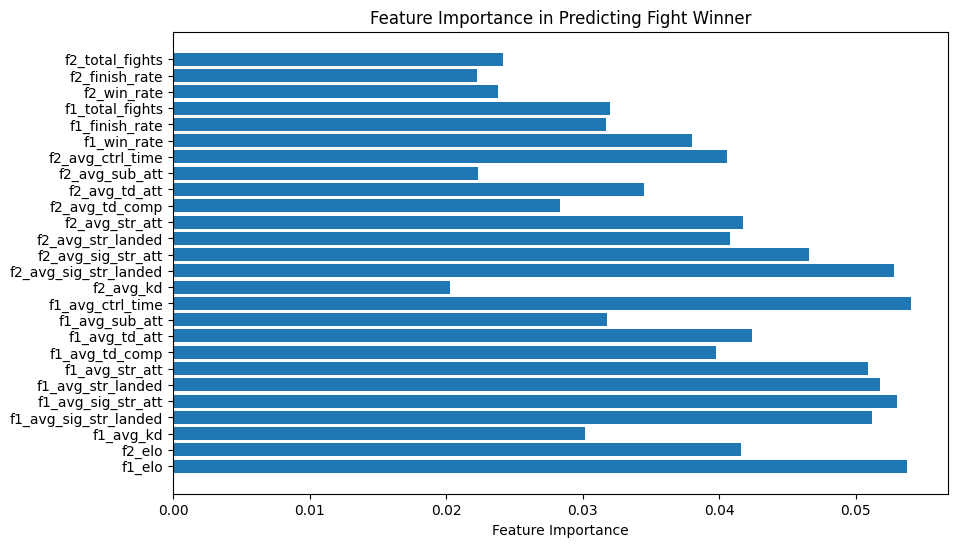

In [381]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Fight Winner")
plt.show()

Train Logistic Regression

In [382]:
from sklearn.linear_model import LogisticRegression

X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

model = LogisticRegression(class_weight='balanced')
model.fit(X_train_clean, y_train_clean)
y_pred = model.predict(X_test_clean)
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.60      0.52       438
           1       0.71      0.59      0.64       737

    accuracy                           0.59      1175
   macro avg       0.59      0.60      0.58      1175
weighted avg       0.62      0.59      0.60      1175



c:\Users\colin\OneDrive\Documents\GitHub\ufc-stat-scraper\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [383]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent', etc.
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model.fit(X_train_imputed, y_train)
y_pred = model.predict(X_test_imputed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51       561
           1       0.74      0.62      0.67      1048

    accuracy                           0.61      1609
   macro avg       0.60      0.61      0.59      1609
weighted avg       0.64      0.61      0.62      1609



c:\Users\colin\OneDrive\Documents\GitHub\ufc-stat-scraper\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Neural network

In [384]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# 1. Impute missing values (if any)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 3. Define model
model = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 4. Compile
model.compile(optimizer='adam', loss='hinge', metrics=['accuracy'])

# 5. Train
model.fit(X_train_scaled, y_train, epochs=40, batch_size=32, validation_split=0.2)

# 6. Evaluate
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))


Epoch 1/40


c:\Users\colin\OneDrive\Documents\GitHub\ufc-stat-scraper\env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6486 - loss: 0.7366 - val_accuracy: 0.6558 - val_loss: 0.6901
Epoch 2/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6530 - loss: 0.6957 - val_accuracy: 0.6558 - val_loss: 0.6889
Epoch 3/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 0.7349 - val_accuracy: 0.6558 - val_loss: 0.6887
Epoch 4/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6422 - loss: 0.7157 - val_accuracy: 0.6558 - val_loss: 0.6886
Epoch 5/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6456 - loss: 0.7087 - val_accuracy: 0.6558 - val_loss: 0.6885
Epoch 6/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 0.7268 - val_accuracy: 0.6558 - val_loss: 0.6885
Epoch 7/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 0.6986 - val_accuracy: 0.6558 - val_loss: 0.6885
Epoch 8/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6493 - loss: 0.7015 - val_accuracy: 0.6558 - val_